``class NeuralNetwork(nn.Module)``を以下のように改装して、改めて学習を行なってください。

- 一つ隠れ層を追加し、``n_units_2``という引数でユニットの数を指定できるように設定しなさい。
- すべての隠れ層に``F.relu``で活性化関数を追加しなさい。
- 出力層に``F.log_softmax``で出力の正規化を行きなさい。

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Load dataset and create splits
iris_dataset = datasets.load_iris()
data = iris_dataset.data

ModuleNotFoundError: No module named 'torch'

In [15]:
X = data[:, :-1]  # sepal length, sepal width, petal length
y = data[:, -1]   # petal width

In [36]:
import pandas as pd
df=pd.DataFrame(data, columns=iris_dataset.feature_names)
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


特徴量のスケールが異なるため、損失関数の勾配のスケールも異なり、最適化プロセスが不安定になる原因になります。

ここで、特徴量（X）とターゲット変数（y）の標準化を行います。これにより、異なるスケールを持つ特徴量を同じスケールに揃えます。

In [16]:
from sklearn.preprocessing import StandardScaler

# データの標準化
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

データ作成

- 学習データ：検証データ：テストデータ＝　$0.7:0.15:0.15$

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)  # 0.25 x 0.8 = 0.2 -> 20% validation

In [18]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [19]:
len(X_train), len(X_val), len(X_test)

(105, 22, 23)

In [20]:
len(y_train), len(y_val), len(y_test)

(105, 22, 23)

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class RegressionNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)#ポイント：中間層を追加します。前の層と後の層のユニット数と合わせる必要があります。
        self.fc3 = nn.Linear(hidden_dim2, 1) # ポイント：回帰のため出力は1つ

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [22]:
# ハイパーパラメータ
learning_rate = 0.01
epochs = 2000
hidden_dim1 = 10
hidden_dim2 = 5

# モデルと最適化のインスタンス化
model = RegressionNN(input_dim=3, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2)
criterion = nn.MSELoss()#ポイント：損失関数はMSEのような回帰用のものを使います。
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
# 学習ループ
for epoch in range(epochs):
    # フォワードパス
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # バックワードパス
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 検証
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val) # ポイント：検証データでの損失も計算します。
    model.train()# ポイント：モデルを訓練モードに戻します。
    
    # 50エポックごとに損失を表示
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [50/2000], Train Loss: 0.1057, Val Loss: 0.0445
Epoch [100/2000], Train Loss: 0.0517, Val Loss: 0.0478
Epoch [150/2000], Train Loss: 0.0453, Val Loss: 0.0462
Epoch [200/2000], Train Loss: 0.0431, Val Loss: 0.0449
Epoch [250/2000], Train Loss: 0.0413, Val Loss: 0.0427
Epoch [300/2000], Train Loss: 0.0401, Val Loss: 0.0411
Epoch [350/2000], Train Loss: 0.0387, Val Loss: 0.0411
Epoch [400/2000], Train Loss: 0.0375, Val Loss: 0.0401
Epoch [450/2000], Train Loss: 0.0364, Val Loss: 0.0378
Epoch [500/2000], Train Loss: 0.0349, Val Loss: 0.0375
Epoch [550/2000], Train Loss: 0.0334, Val Loss: 0.0383
Epoch [600/2000], Train Loss: 0.0321, Val Loss: 0.0386
Epoch [650/2000], Train Loss: 0.0312, Val Loss: 0.0407
Epoch [700/2000], Train Loss: 0.0303, Val Loss: 0.0383
Epoch [750/2000], Train Loss: 0.0293, Val Loss: 0.0402
Epoch [800/2000], Train Loss: 0.0282, Val Loss: 0.0425
Epoch [850/2000], Train Loss: 0.0275, Val Loss: 0.0431
Epoch [900/2000], Train Loss: 0.0270, Val Loss: 0.0424
Epoch [950/

In [24]:
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# データをnumpy形式に変換
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.numpy()

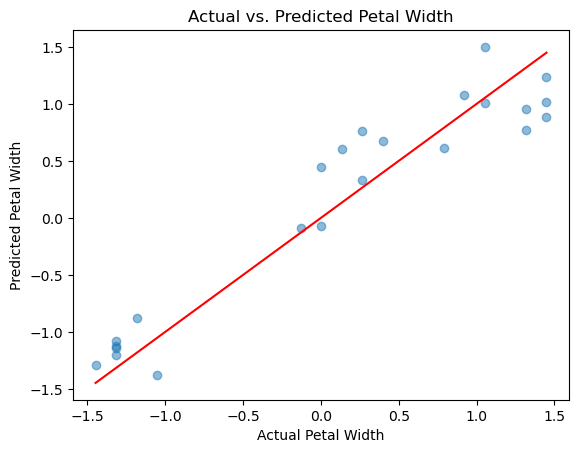

In [30]:
plt.scatter(y_test_np, test_predictions_np,alpha=0.5)
plt.xlabel("Actual Petal Width")
plt.ylabel("Predicted Petal Width")
plt.title("Actual vs. Predicted Petal Width")
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red')
plt.show()